<H1 align="center">Исследование поведения пользователей мобильного приложения.</H1><br><br>


**Цель исследования:**
- *Изучить воронку продаж внутри мобильного приложения.*
- *Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки и сколько «застревает» на предыдущих шагах. Определить на каких именно шагах у пользователей возникают трудности.*
- *Исследовать результаты A/A/B-эксперимента и определить наиболее эффективную группу тестирования.*

**Описание данных:**
- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события;
- **ExpId** — номер эксперимента: **246** и **247** — контрольные группы, а **248** — экспериментальная.

**Оглавление:**<br>
- [1. Изучение общей информации](#num1)<br>
- [2. Подготовка данных](#num2)<br>
 - [2.1 Вывод](#num21)<br>
- [3. Изучение и проверка данных](#num3)<br>
 - [3.1 Вывод](#num31)<br>
- [4. Изучение воронки событий](#num4)<br>
 - [4.1 Вывод](#num41)<br>
- [5. Изучение результатов эксперимента](#num5)<br>
- [6. Общий вывод](#num6)<br>

<a id="num1"></a>
## Изучение общей информации

In [44]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display

from scipy import stats as st
import math as mth

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px 
from plotly import graph_objects as go

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # регистрация форматеров и конвертеров pandas в matplotlib

In [45]:
# прочтём датафрейм, уберём из него нестандартный разделитель '\t'
data = pd.read_csv('logs_exp.csv', sep='\t')
df = data.copy()

# установим максимальную ширину столбца для таблиц
pd.set_option('max_colwidth', 110)

ClrR = '\033[1;91m'  # переменная для выделения текста красным и жирным цветом 
ClrB = '\033[1m'     # переменная для выделения текста жирным цветом 
ClrD = '\033[0m'     # переменная для выделения текста с настройками по-умолчанию

# выведем общую информацию датафрейма на экран
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


*Датафрейм состоит из 4 колонок и 244126 строк, пропущенных значений не обнаружено. Названия колонок находятся в верхнем регистре.*

<a id="num2"></a>
## Подготовка данных

Для проведения анализа данных, нам нужно очистить датафрейм и привести его к корректному виду:

- Изменить названия колонок на более удобные, привести их к нижнему регистру;
- Добавить новые столбцы с датой и временем совершения события;
- Удалить дубликаты, проверить пропуски и типы данных.

In [46]:
# переименуем колонки
df = df.rename(columns={
    'EventName': 'event', 
    'DeviceIDHash': 'user', 
    'EventTimestamp': 'timestamp',
    'ExpId': 'exp_id',
}
              )

# приведём колонку 'eventtimestamp' к типу 'datetime'
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = pd.to_datetime(df['timestamp'], unit='s').dt.date


# разместим колонки датафрейма в нужном порядке, колонку 'timestamp' исключим из датафрейма
df = df[['event', 'user', 'exp_id', 'datetime', 'date']]


display(df.head())

,event,user,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25


In [47]:
# найдём количество пропущенных значений и дубликатов
print('Количество пропущенных значений:', ClrB, df.isna().sum().sum(), ClrD) 
print('Количество дубликатов: ', ClrB, df.duplicated().sum(), ClrD)
print('Процент дубликатов:', ClrB, '{:.1%}'.format((df.duplicated().sum() / len(df))), ClrD)

Количество пропущенных значений:  0 
Количество дубликатов:   413 
Процент дубликатов:  0.2% 


In [48]:
# посмотрим распределение дубликатов по колонке 'event'
display(df[df.duplicated()]['event'].value_counts())

PaymentScreenSuccessful    195
MainScreenAppear           104
CartScreenAppear            63
Tutorial                    34
OffersScreenAppear          17
Name: event, dtype: int64

In [49]:
# удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов после удаления: ', ClrB, df.duplicated().sum(), ClrD, end='\n\n')

Количество дубликатов после удаления:   0 



In [50]:
# проверим, входят ли пользователи более чем в одну группу
print('Количество пользователей, входящих более, чем в одну группу:', \
      ClrB, len(df.groupby('user').agg({'exp_id': 'nunique'}).query('exp_id > 1')), ClrD)

Количество пользователей, входящих более, чем в одну группу:  0 


In [51]:
# выведем общую информацию датафрейма на экран
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     243713 non-null  object        
 1   user      243713 non-null  int64         
 2   exp_id    243713 non-null  int64         
 3   datetime  243713 non-null  datetime64[ns]
 4   date      243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


None

<a id="num21"></a>
### Вывод

*В ходе подготовки данных, были изменены названия колонок фатафрейма, добавлены столбцы **datetime** и **date**, найденно и удалено **413** дубликатов или **0.2%**. После удаления дубликатов, из **244126** строк исходного датафрейма, осталось **243713** строк.*

<a id="num3"></a>
## Изучение и проверка данных

Определим период исследования.

In [52]:
# найдём начало и конец проведения исследования
print('Начало проведения исследования: ', ClrB, df['datetime'].min(), ClrD)
print('Конец проведения исследования: ', ClrB, df['datetime'].max(), ClrD)

Начало проведения исследования:   2019-07-25 04:43:36 
Конец проведения исследования:   2019-08-07 21:15:17 


*Таким образом в датафрейме представлены данные за две недели: с **25 июля 04:43** по **7 августа 21:15 2019** года.*

Изучим, насколько имеющиеся данные являются полными, рассмотрим распределение количества пользователей для каждого события по дате и времени начала.

In [53]:
# напишем функцию для постройки гистограмм
def buildHist(data, xname, yname, title):
    plt.figure(figsize=(16, 6))
    data.hist(bins=150)
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=45, horizontalalignment='center')
    plt.yticks(horizontalalignment='right')
    plt.show()
    
# напишем функцию для постройки сдолбчатой диаграммы
def buildBar(data, xname, yname, title):
    data.plot(kind='bar', width=0.8, figsize=(16, 6), legend=False)
    plt.title(title)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.xticks(rotation=0, horizontalalignment='center')
    plt.yticks(horizontalalignment='right')
    plt.show()

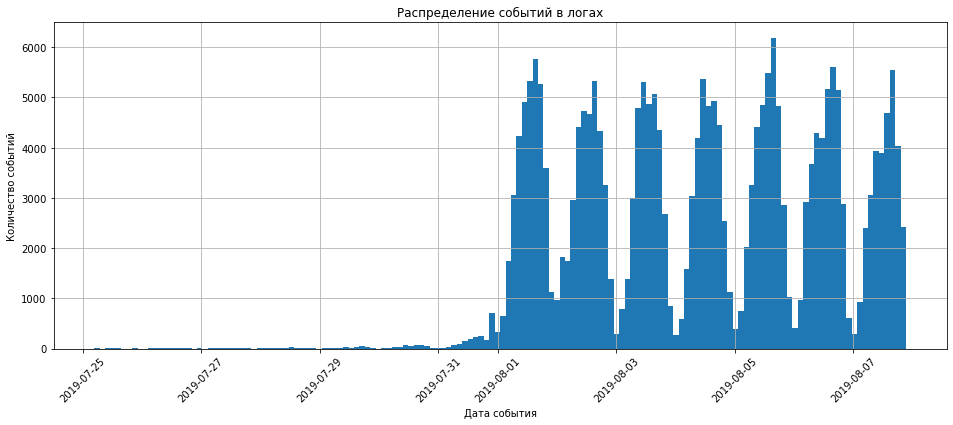

In [54]:
# построим гистограму для 'datetime'
buildHist(
    df.datetime, 
    'Дата события', 
    'Количество событий', 
    'Распределение событий в логах', 
)

*Из гистограммы видно, что наш лог состоит из неполных данных. Резкий подъём графика начинается от середины графика, с **2019-08-01** до **2019-08-07**. То есть мы распологаем данными только за семь дней. Это может быть связано с перекосом данных, вследствии перехода событий из предыдущего периода времени.*

Отбросим более старые данные.

,event,user,exp_id,datetime,date
0,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:00,2019-08-01
1,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:55,2019-08-01
2,OffersScreenAppear,3737462046622621720,246,2019-08-01 00:08:58,2019-08-01
3,MainScreenAppear,1433840883824088890,247,2019-08-01 00:08:59,2019-08-01
4,MainScreenAppear,4899590676214355127,247,2019-08-01 00:10:15,2019-08-01


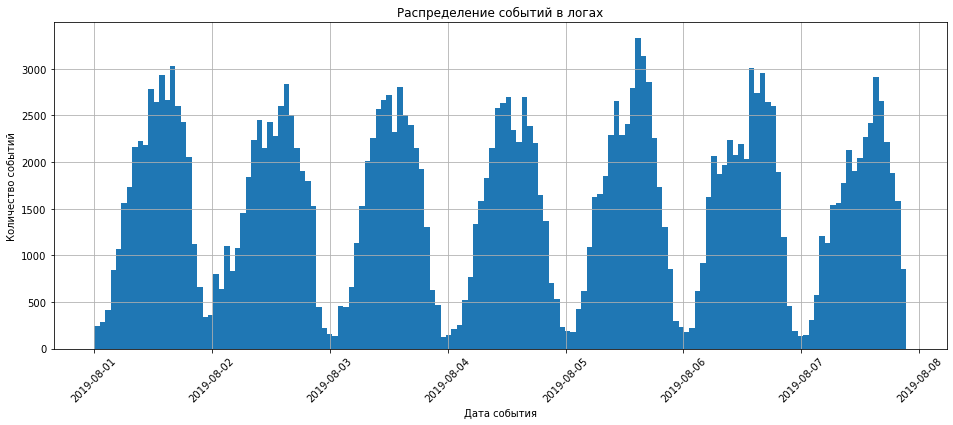

In [55]:
# определим неполные данные и отбросим их методом shift(), fillna(), dropna()
df = df.groupby('date').apply(lambda x: x[(x['datetime'] > '2019-08-01').shift().fillna(False)])
df = df.dropna().reset_index(drop=True)

display(df.head())

# построим гистограму для 'datetime'
buildHist(
    df.datetime, 
    'Дата события', 
    'Количество событий', 
    'Распределение событий в логах', 
)

Проверим, много ли событий и пользователей потерялось, если отбросить старые данные.

In [56]:
# выведем общую информацию датафрейма на экран
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240880 entries, 0 to 240879
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     240880 non-null  object        
 1   user      240880 non-null  int64         
 2   exp_id    240880 non-null  int64         
 3   datetime  240880 non-null  datetime64[ns]
 4   date      240880 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.2+ MB


*По итогам проверки, были отброшены строки до **31 июля 2019 года** включительно, так как количество зарегистрированных событий в этот период, было намного меньше, чем за период с **1 по 7 августа 2019 года**.*

*В датафрейме осталось **240880** событий из **243713**, всего мы потеряли **2833** событий или **0.99%**, что не повлияет на результат тестирования.*

Проверим, что в датафрейме есть пользователи из всех трёх экспериментальных групп.

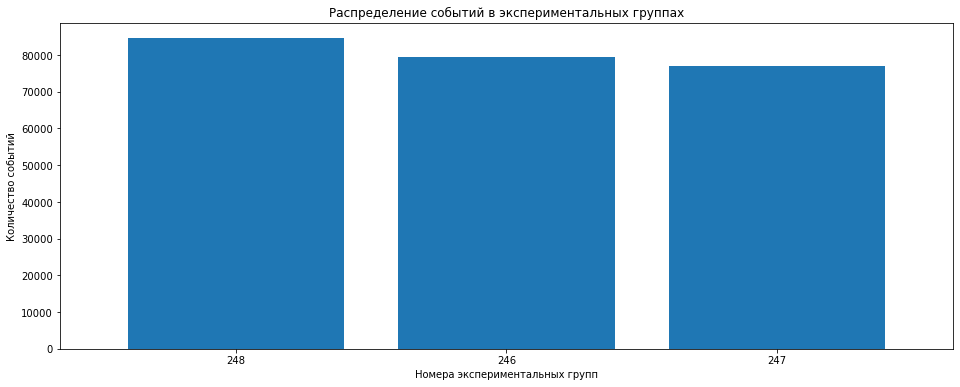

In [57]:
# построим гистограму для экспериментальных групп
buildBar(
    df['exp_id'].value_counts(), 
    'Номера экспериментальных групп', 
    'Количество событий', 
    'Распределение событий в экспериментальных группах', 
)

*По графику распределения событий в группах мы можем видеть, что в датафрейме находятся данные всех групп.*

Найдём, сколько всего событий и пользователей в логе. Сколько в среднем событий приходится на одного пользователя.

In [58]:
# найдём количество событий в логе
print('Количество событий в логе:', ClrB, df['event'].count(), ClrD)

# найдём количество пользователей в логе
print('Количество пользователей в логе:', ClrB, df['user'].value_counts().count(), ClrD)

# найдём сколько в среднем событий приходится на пользователя
print('Сколько в среднем событий приходится на пользователя:',
      ClrB, round(df['event'].count() / df['user'].value_counts().count()), ClrD)

Количество событий в логе:  240880 
Количество пользователей в логе:  7534 
Сколько в среднем событий приходится на пользователя:  32 


<a id="num31"></a>
### Вывод

1. *В результате проверки, отброшены строки с данными до **31 июля 2019 года** включительно. В датафрейме осталось **240880** событий из **243713**, всего мы потеряли **2833** событий или **0.99%**.*
2. *При изучении данных мы определили, что:*
 * *Количество событий в логе: **240880**.*
 * *Количество пользователей в логе:  **7534**.*
 * *Сколько в среднем событий приходится на пользователя:  **32**.*
 * *В датафрейме находятся данные всех групп*

<a id="num4"></a>
## Изучение воронки событий

Определим: 
- какие события есть в логах 
- как часто события встречаются, отсортируем их по частоте 
- сколько пользователей совершали каждое из этих событий, отсортируем события по числу пользователей
- долю пользователей, которые хоть раз совершали событие.

In [59]:
# сгруппируем датафрейм по колонке 'event'
result = df.groupby('event', sort=False).agg({'event': ['count'], 'user': ['nunique']}).reset_index()
result.columns = ['События', 'Количество событий', 'Количество пользователей']
result = result.sort_values(by='Количество событий', ascending=False)

# посчитаем долю пользователей, которые хоть раз совершали событие
result['Доля пользователей на событие, %'] = round(result['Количество пользователей'] / df.user.nunique() * 100, 2)

display(result)

,События,Количество событий,Количество пользователей,"Доля пользователей на событие, %"
0,MainScreenAppear,117324,7419,98.47
1,OffersScreenAppear,46332,4593,60.96
3,CartScreenAppear,42302,3734,49.56
4,PaymentScreenSuccessful,33918,3539,46.97
2,Tutorial,1004,840,11.15


*В логах находится **243713** событий в **5** вариантах, это:*

- **MainScreenAppear** – «Посещение главного экрана» (главаная страница приложения);
- **OffersScreenAppear** – «Предложение на главном экране» (каталог);
- **CartScreenAppear** – «Появление экрана корзины» (добавление товара в корзину);
- **PaymentScreenSuccessful** – «Экран успешной оплаты» (оплата товара);
- **Tutorial** – «Руководство».

*Вероятно, что пользователи, открыв приложение, попадают на главную страницу приложения (**MainScreenAppear**). Там они должны прочитать руководство пользователя (**Tutorial**), затем перейти в каталог, выбрать (**CartScreenAppear**) и оплатить товар (**PaymentScreenSuccessful**).*

*Однако, только часть пользователей проходит последовательно все варианты событий, а часть пользователей по каким-либо причинам вообще не заходит в приложение, так например:*

- **MainScreenAppear** – **98,47%** от всех зарегистрированных пользователей попали на главную страницу приложения;
- **OffersScreenAppear** – **60,96%** в каталог;
- **CartScreenAppear** – **49,56%** добавили товар в корзину;
- **PaymentScreenSuccessful** – **46,97%** купили товар;
- **Tutorial** – **11,15%** зашли в руководство пользователя.

*На практике, «руководство» (**Tutorial**) мало кто читает, такое событие нарушает последовательность событий при расчёте воронки событий. Поэтому, «руководство» мы можем не учитывать при расчёте воронки событий.*

In [60]:
# исключим «руководство» из датафрейма
df = df[df['event'] != 'Tutorial']

# перепишем таблицу
result = df.groupby('event', sort=False).agg({'event': ['count'], 'user': ['nunique']}).reset_index()
result.columns = ['События', 'Количество событий', 'Количество пользователей']
result = result.sort_values(by='Количество событий', ascending=False)
# посчитаем долю пользователей, которые хоть раз совершали событие
result['Доля пользователей на событие, %'] = round(result['Количество пользователей'] / df.user.nunique() * 100, 2)

display(result)

,События,Количество событий,Количество пользователей,"Доля пользователей на событие, %"
0,MainScreenAppear,117324,7419,98.53
1,OffersScreenAppear,46332,4593,61.00
2,CartScreenAppear,42302,3734,49.59
3,PaymentScreenSuccessful,33918,3539,47.00


Построим диаграмму воронки событий.

In [61]:
# переименуем названия событий в колонке 'События'
col_funnel = result.rename(index={0: 'Посещение главного экрана', 
                                  1: 'Предложение на главном экране', 
                                  2: 'Появление экрана корзины', 
                                  3: 'Экран успешной оплаты', 
                                 }
                          ).reset_index()

# построим график воронки
fig = go.Figure(go.Funnel(
    y = col_funnel['index'], 
    x = col_funnel['Количество пользователей'], 
    textinfo = 'value+percent initial', 
    marker = {'color': ['#3366cc', '#dc3912', '#ff9900', '#109618', '#990099'], 
              'line': {'width': [4, 2, 2, 3, 1, 1], 
                       'color': ['wheat', 'blue', 'wheat', 'wheat', 'wheat'], 
                      }
             }
)
               )
fig.update_layout(template='simple_white',
                  title='<b>Воронка событий в приложении.</b>')

fig.show()

![Воронка событий в приложении](img/funnel.png)

In [62]:
# посчитаем, какая доля пользователей проходит на следующий шаг воронки
result['Конверсия'] = result['Количество пользователей'].shift(periods=1, fill_value=0)

def cr(row):
    
    '''Функция для нахождения конверсии в шаг'''
    
    count_cr = row['Конверсия']
    count = row['Количество пользователей']
    if count_cr == 0:
        return 100
    else:
        return (count / count_cr) * 100

result['Конверсия в шаг, %'] = result.apply(cr, axis=1).round(2)

display(result)
print()

# найдём долю пользователей дошедших от первого события до оплаты
share_cr = round(result['Количество пользователей'][3] / result['Количество пользователей'][0] * 100, 2)
print(f'Доля пользователей дошедшая от первого события до оплаты:', ClrB, f'{share_cr} %', ClrD)

,События,Количество событий,Количество пользователей,"Доля пользователей на событие, %",Конверсия,"Конверсия в шаг, %"
0,MainScreenAppear,117324,7419,98.53,0,100.00
1,OffersScreenAppear,46332,4593,61.00,7419,61.91
2,CartScreenAppear,42302,3734,49.59,4593,81.30
3,PaymentScreenSuccessful,33918,3539,47.00,3734,94.78



Доля пользователей дошедшая от первого события до оплаты:  47.7 % 


<a id="num41"></a>
### Вывод
*Исследование воронки показывает, что после главной страницы, в каталог заходят только **61.91%** посетителей приложения, в корзину добавляет товар - **81.30%** от количества посетителей предыдущего шага. Оплачивают **94,78%** посетителей от добавивших товар в корзину. Самые большие потери происходят на этапе перехода из главной страницы на страницу каталога - **38%** не доходят до второго этапа.*

*Доля пользователей дошедшая от первого события до оплаты - **47.7 %**.*

<a id="num5"></a>
## Изучение результатов эксперимента

Посмотрим сколько пользователей в каждой экспериментальной группе.

In [63]:
# составим сводную таблицу количества пользователей совершивших каждое событие в группах
funnel = (
    df
    .groupby(['exp_id', 'event']).agg({'user':'nunique'})
    .pivot_table(index='event', columns='exp_id', values='user')
    .reset_index()
    .sort_values(246, ascending=False)
)

# количество уникальных пользователей в каждой экспериментальной группе
trials = df.groupby('exp_id').agg({'user':'nunique'}).reset_index()

print(ClrB, 'Количество уникальных пользователей:', ClrD)
print(' В группе 246 составляет:', ClrB, trials.iloc[0]['user'], ClrD, 'человек;')
print(' В группе 247 составляет:', ClrB, trials.iloc[1]['user'], ClrD, 'человек;')
print(' В группе 248 составляет:', ClrB, trials.iloc[2]['user'], ClrD, 'человек.', end='\n\n\n')

print(ClrB, 'Количество пользователей совершивших каждое событие в группах:', ClrD)
display(funnel)

 Количество уникальных пользователей: 
 В группе 246 составляет:  2483  человек;
 В группе 247 составляет:  2512  человек;
 В группе 248 составляет:  2535  человек.


 Количество пользователей совершивших каждое событие в группах: 


exp_id,event,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Напишем функцию для расчёта статистически значимой разницы между долями двух генеральных совокупностей.

In [64]:
# списки с количеством пользователей для каждого события в каждой группе
# 246 экспериментальная группа:
A1_list = [trials.iloc[0]['user'], funnel.iloc[0][246], funnel.iloc[1][246], funnel.iloc[2][246], funnel.iloc[3][246]]
# 247 экспериментальная группа:
A2_list = [trials.iloc[1]['user'], funnel.iloc[0][247], funnel.iloc[1][247], funnel.iloc[2][247], funnel.iloc[3][247]]
# 248 экспериментальная группа:
B_list = [trials.iloc[2]['user'], funnel.iloc[0][248], funnel.iloc[1][248], funnel.iloc[2][248], funnel.iloc[3][248]]


def check_hypothesis(first_list, second_list):
    
    '''функция для расчёта статистически значимой разницы
       между долями двух генеральных совокупностей
    '''
    
    # список событий  
    event_list = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
    
    # цикл для вычисления p-value и проверки нулевой гипотезы каждого события 
    for x in range(0, len(first_list)-1):
        x1 = first_list[x+1]  # второе значение в первой группе 
        x2 = second_list[x+1] # второе значение во второй группе
        y1 = first_list[x]    # первое значение в первой группе
        y2 = second_list[x]   # первое значение во второй группе
    
        alpha = .01 # критический уровень статистической значимости
        successes = np.array([x1, x2])
        trials = np.array([y1, y2])
        p1 = successes[0]/trials[0] # пропорция успехов в первой группе
        p2 = successes[1]/trials[1] # пропорция успехов во второй группе
        
        # пропорция успехов в комбинированном датасете
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2  # разница пропорций в датасетах
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        # стандартное нормальное распределение (среднее - 0, ст.отклонение - 1)
        distr = st.norm(0, 1)
        # расчёт значения статистической разницы между группами
        p_value = 1 - distr.cdf(z_value)
        
        # выведем результаты на экран
        print('Событие:  ', ClrB, event_list[x], ClrD)
        print('p_value:  ', ClrB, p_value, ClrD)
        
        # сравненим p-value с установленным уровнем статистической значимости 
        if (p_value < alpha):
            print('Результат:', ClrB, 'Нулевая гипотеза отвергнута: между долями есть значимая разница', ClrD)
        else:
            print('Результат:', ClrB, 'Нулевая гипотеза не отвергнута: нет оснований считать доли разными', ClrD)
        print()

Проверим, находят ли статистические критерии, разницу между выборками **246** и **247** (A/A – тест).

In [65]:
# применим функцию 'check_hypothesis' для групп А1 и А2 [246 и 247]
check_hypothesis(A1_list, A2_list)

Событие:    MainScreenAppear 
p_value:    0.3763351718241519 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    OffersScreenAppear 
p_value:    0.1311172479627889 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    CartScreenAppear 
p_value:    0.31968773565726316 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    PaymentScreenSuccessful 
p_value:    0.09121719704033826 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 



Найдём самое популярное событие.

In [66]:
# составим сводную таблицу количества пользователей совершивших событие
display(df.groupby('event', sort=False).agg({'user': 'nunique'}).reset_index())

,event,user
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


*Самое популярное событие — **MainScreenAppear** (Посещение главной страницы), его совершили **7419** пользователей.*

Посчитаем число пользователей, совершивших события в каждой из контрольных групп. Посчитаем долю пользователей, совершивших эти события.

In [67]:
# посчитаем долю пользователей, которые хоть раз совершали событие в каждой группе
# группа 246
result_246 = df.query("exp_id == 246").groupby(['event', 'exp_id'], sort=False).agg({'user': ['nunique']}).reset_index()
result_246.columns = ['События', 'Эксперимент', 'Количество пользователей']
result_246 = result_246.sort_values(by=['Количество пользователей'], ascending=False)
result_246['Доля пользователей на событие, %'] = round(result_246['Количество пользователей'] / df.user.nunique() * 100, 2)

# группа 247
result_247 = df.query("exp_id == 247").groupby(['event', 'exp_id'], sort=False).agg({'user': ['nunique']}).reset_index()
result_247.columns = ['События', 'Эксперимент', 'Количество пользователей']
result_247 = result_247.sort_values(by=['Количество пользователей'], ascending=False)
result_247['Доля пользователей на событие, %'] = round(result_247['Количество пользователей'] / df.user.nunique() * 100, 2)

# группа 248
result_248 = df.query("exp_id == 248").groupby(['event', 'exp_id'], sort=False).agg({'user': ['nunique']}).reset_index()
result_248.columns = ['События', 'Эксперимент', 'Количество пользователей']
result_248 = result_248.sort_values(by=['Количество пользователей'], ascending=False)
result_248['Доля пользователей на событие, %'] = round(result_248['Количество пользователей'] / df.user.nunique() * 100, 2)

display(result_246)
display(result_247)
display(result_248)

,События,Эксперимент,Количество пользователей,"Доля пользователей на событие, %"
0,MainScreenAppear,246,2450,32.54
1,OffersScreenAppear,246,1542,20.48
3,CartScreenAppear,246,1266,16.81
2,PaymentScreenSuccessful,246,1200,15.94


,События,Эксперимент,Количество пользователей,"Доля пользователей на событие, %"
0,MainScreenAppear,247,2476,32.88
1,OffersScreenAppear,247,1520,20.19
3,CartScreenAppear,247,1238,16.44
2,PaymentScreenSuccessful,247,1158,15.38


,События,Эксперимент,Количество пользователей,"Доля пользователей на событие, %"
0,MainScreenAppear,248,2493,33.11
3,OffersScreenAppear,248,1531,20.33
1,CartScreenAppear,248,1230,16.33
2,PaymentScreenSuccessful,248,1181,15.68


*Значимые отличия по количеству пользователей, по доле пользователей совершивших событие между группами отсутствуют.*

Определим гипотезы:

- **H0** — доли пользователей, выполнивших Событие в группах A и B равны;
- **H1** — доли пользователей, выполнивших Событие в группах A и B не равны.

In [68]:
# применим функцию 'check_hypothesis' для групп А1 и B [246 и 248]
check_hypothesis(A1_list, B_list)

Событие:    MainScreenAppear 
p_value:    0.1693557038079644 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    OffersScreenAppear 
p_value:    0.13421407936246155 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    CartScreenAppear 
p_value:    0.1056085409027343 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    PaymentScreenSuccessful 
p_value:    0.928523293647905 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 



In [69]:
# применим функцию 'check_hypothesis' для групп А2 и B [247 и 248]
check_hypothesis(A2_list, B_list)

Событие:    MainScreenAppear 
p_value:    0.25974821770258516 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    OffersScreenAppear 
p_value:    0.5065317373577742 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    CartScreenAppear 
p_value:    0.21824517565311274 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    PaymentScreenSuccessful 
p_value:    0.9971612673021318 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 



Сравним результаты теста с объединённой контрольной группой.

In [70]:
# создадим объединенную экспериментальную группу А
A_list = []
for x in range(len(A1_list)):
    A_list.append(A1_list[x] + A2_list[x])

# применим функцию 'check_hypothesis' для групп А и B
check_hypothesis(A_list, B_list)

Событие:    MainScreenAppear 
p_value:    0.1743342145546628 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    OffersScreenAppear 
p_value:    0.2654294716038812 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    CartScreenAppear 
p_value:    0.11952977139973686 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 

Событие:    PaymentScreenSuccessful 
p_value:    0.9914427828402265 
Результат:  Нулевая гипотеза не отвергнута: нет оснований считать доли разными 



*Статистически значимых различий между группами **246** и **248**, группами **247** и **248**, объединенной контрольной группой и **248** при p-value, равному **0.01**, не выявлено.* 

*Таким образом, изменение шрифта не повлияло на поведение пользователей.*

<a id="num6"></a>
## Общий вывод

*Мы провели анализ логов пользователей мобильного приложения стартапа по продаже продуктов питания за период с **1** по **7 августа 2019 года**. Данные за период с **25** по **31 июля 2019 года** нам пришлось отбросить из-за их неполноты.*

*В результате анализа мы определили последовательность действий пользователей: чаще всего они заходят на главную страницу, потом в каталог, затем в корзину и оплачивают заказ. «Руководством» воспользовались только **11%** пользователей. В среднем, каждый пользователь совершает **32** события в приложении.*

*Исследование воронки показывает, что после главной страницы, в каталог заходят только **61.91%** посетителей приложения, в корзину добавляет товар - **81.30%** от количества посетителей предыдущего шага. Оплачивают **94,78%** посетителей от добавивших товар в корзину. Самые большие потери происходят на этапе перехода из главной страницы на страницу каталога - **38%** не доходят до второго шага. От первого шага до оплаты доходят только **47,7%** пользователей. Необходимо изучить проблемы связанные с переходом с главной страницы (событие **MainScreenAppear**) в каталог (событие **OffersScreenAppear**).*

*Все группы распределены почти равномерно: в 246 группе - **32.54%** пользователей, в 247 группе - **32.88%**, в 248 группе - **33.11%** от общего числа пользователей. При проведении **12** экспериментов (A/А/В–тестов) статистически значимые различия между тестируемыми группами при p-value, равном **0.01**, не выявлено. Таким образом, изменение шрифта не повлияло на поведение пользователей.*

